In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter, namedtuple
import shap
from tqdm import tqdm
from collections import Counter, defaultdict
shap.initjs()

## Data Exploration

In [2]:
DATA_FOLDER = '../../data/music/'

TRAIN_FILE = os.path.join(DATA_FOLDER, 'train.csv')
MEMBERS_FILE = os.path.join(DATA_FOLDER, 'members.csv')
SONGS_FILE = os.path.join(DATA_FOLDER, 'songs.csv')
SONGS_EXTRA_FILE = os.path.join(DATA_FOLDER, 'song_extra_info.csv')

In [3]:
SEED = 13
FOLDS = 5

In [18]:
train_df = pd.read_csv(
    TRAIN_FILE, 
    dtype={
        'msno': 'category', 
        'song_id': 'category', 
        'source_system_tab': 'category',
        'source_screen_name': 'category',
        'source_type': 'category',
        'target': np.int32
    }
)

In [19]:
members_df = pd.read_csv(
    MEMBERS_FILE,
    dtype={
        'msno': 'category',
        'city': 'category',
        'bd': np.int,
        'gender': 'category',
        'registered_via': 'category',
        'registration_init_time': np.int,
        'expiration_date': np.int
    }
)

In [14]:
songs_df = pd.read_csv(
    SONGS_FILE,
    dtype={
        'song_id': 'category',
        'song_length': np.int,
        'genre_ids': str,
        'artist_name': str,
        'composer': str,
        'lyricist': str,
        'language': 'category'
    }
)

In [17]:
songs_extra_df = pd.read_csv(
    SONGS_EXTRA_FILE,
    dtype={
        'song_id': 'category',
        'name': str,
        'isrc': str
    }
)

### Training data
* Almost perfectly balanced
* Has some categorical features about the source of the listening event

In [ ]:
train_df[train_df.target == 1].head(10)

In [ ]:
train_df[train_df.target == 0].head(10)

In [ ]:
train_df.target.value_counts()

In [ ]:
train_df.target.value_counts() / len(train_df)

In [ ]:
train_df.source_system_tab.value_counts()

In [ ]:
train_df.source_screen_name.value_counts()

In [ ]:
train_df.source_type.value_counts()

### Members data
* Requires some cleaning
* bd column has some obvious outliers (negative or too large values), we might want to do something about them
* gender is missing for some members

In [12]:
members_df.head(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,43,female,9,20120703,20171006
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,0,NaN,4,20160326,20160329
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,0,NaN,7,20160130,20170930
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,0,NaN,7,20110111,20170930
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,0,NaN,7,20160217,20170613


In [13]:
members_df[members_df.bd < 0]

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
11834,w8E2bY1kVYnLch27rTbD70PBg4mKLifbXUwnJ7oRnaw=,6,-38,NaN,9,20150210,20180420
24301,0YPMbwSq0IhioFJ6VGVjgRFkM5QMWAp5VgXH9dmwgII=,13,-43,NaN,9,20150227,20170925


In [14]:
members_df['bd_clean'] = members_df.bd
members_df.loc[(members_df.bd < 0) | (members_df.bd >= 80), 'bd_clean'] = 0

In [15]:
members_df['bd_clean'].describe()

count    34403.000000
mean        12.106502
std         15.391103
min          0.000000
25%          0.000000
50%          0.000000
75%         25.000000
max         78.000000
Name: bd_clean, dtype: float64

In [16]:
members_df.gender.cat.add_categories('unspecified', inplace=True)

In [17]:
members_df.loc[pd.isna(members_df.gender), 'gender'] = 'unspecified'

In [18]:
members_df.gender.value_counts()

unspecified    19902
male            7405
female          7096
Name: gender, dtype: int64

In [19]:
members_df.head(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,bd_clean
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,unspecified,7,20110820,20170920,0
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,unspecified,7,20150628,20170622,0
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,unspecified,4,20160411,20170712,0
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,unspecified,9,20150906,20150907,0
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,unspecified,4,20170126,20170613,0
5,zgPOEyUn5a/Fvuzb3m69ajzxjkbblVtObglW89FzLdo=,13,43,female,9,20120703,20171006,43
6,Sw9AT8QoR4wWiNUqHZUH6g5ahzGUx4lo1g+Y3xE2f2M=,1,0,unspecified,4,20160326,20160329,0
7,pg6bT2XZkSP1TDBy4qn3HBPY/HffKQ/bg8WIISQYBSY=,1,0,unspecified,7,20160130,20170930,0
8,kfk1AdTNH2dNqF5LzIs4e0vwGPejw2jrnFjJlcYnEgk=,1,0,unspecified,7,20110111,20170930,0
9,tscijwx4dbEp0NXGl+iFtHJ8zrj+TkcMrduOQk9t+gE=,1,0,unspecified,7,20160217,20170613,0


### Songs data
* Contains several columns with list data

In [20]:
songs_df.head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,NaN,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


In [21]:
def process_splittable_column(df, col_name):
    item_count = Counter()    
    
    def process_splittable_col(col_list):
        if pd.isna(col_list):
            col_list = ""
        items = [item.strip() for item in col_list.split('|')]
        for item in items:
            item_count[item] += 1
        return items

    df[col_name] = df[col_name].map(process_splittable_col)
    
    return item_count

In [22]:
# genres = process_splittable_column(songs_df, 'genre_ids')
# artists = process_splittable_column(songs_df, 'artist_name')
# composers = process_splittable_column(songs_df, 'composer')
# lyricists = process_splittable_column(songs_df, 'lyricist')

In [23]:
songs_df.head(10)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
5,kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=,235520,864|857|850|843,貴族精選,Joe Hisaishi,Hayao Miyazaki,17.0
6,N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=,226220,458,伍佰 & China Blue,Jonathan Lee,NaN,3.0
7,GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=,276793,465,光良 (Michael Wong),光良,彭資閔,3.0
8,oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=,228623,465,林俊傑 (JJ Lin),JJ Lin,Wu Qing Feng,3.0
9,btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=,232629,352|1995,Kodaline,Stephen Garrigan| Mark Prendergast| Vincent Ma...,Stephen Garrigan| Mark Prendergast| Vincent Ma...,52.0


### Songs extra data
* ISRC contains some valuable information like country, registrant, and issue year

In [24]:
songs_extra_df.head(10)

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001
5,QU8f6JR0/cwLGSqJX2XDVzFK0DxMaIUY15ALJXK7ziw=,Our Time,GBAYE1400079
6,O1Oj4CmnZhbHl7oyBaHSpGeu5gvcSmUydY3Awmv3uxk=,癢,HKUM70704066
7,Tr5R61AuEkN8UelOCzu09ZwQi7/HmP9sQmxf9rFngIg=,Aloha| E Komo Mai (Theme Song from Lilo & Stit...,USWD10423930
8,ie9l12ZYXEaP4evrBBUvnNnZGdupHSX5NU+tEqB1SDg=,每天愛你多一些,HKA610200010
9,6mICNlckUVGuoK/XGC7bnxXf5s2ZnkpFHShaGL/zM2Y=,你是你的,TWI431000103


In [25]:
ISRC = namedtuple('ISRC', ('country', 'registrant', 'year', 'id'))

def parse_isrc(isrc):
    if pd.isna(isrc):
        return ISRC(np.nan, np.nan, 0, np.nan)
    country = isrc[:2]
    registrant = isrc[2:5]
    year = int(isrc[5:7])
    if year <= 20:
        year += 2000
    else:
        year += 1900
    identifier = isrc[7:]
    return ISRC(country, registrant, year, identifier)

In [26]:
songs_extra_df['isrc_parsed'] = songs_extra_df.isrc.map(parse_isrc)

In [27]:
songs_extra_df['isrc_country'] = songs_extra_df['isrc_parsed'].map(lambda isrc: isrc.country).astype('category')
songs_extra_df['isrc_year'] = songs_extra_df['isrc_parsed'].map(lambda isrc: isrc.year).astype(np.int)
songs_extra_df['isrc_registrant'] = songs_extra_df['isrc_parsed'].map(lambda isrc: isrc.registrant).astype('category')

In [28]:
songs_extra_df = songs_extra_df.drop(['name', 'isrc', 'isrc_parsed'], axis=1)

In [29]:
songs_extra_df.head(10)

,song_id,isrc_country,isrc_year,isrc_registrant
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,TW,2012,UM7
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,QM,2016,ZSY
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,TW,2008,A53
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,US,2013,SM1
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,TW,2013,A47
5,QU8f6JR0/cwLGSqJX2XDVzFK0DxMaIUY15ALJXK7ziw=,GB,2014,AYE
6,O1Oj4CmnZhbHl7oyBaHSpGeu5gvcSmUydY3Awmv3uxk=,HK,2007,UM7
7,Tr5R61AuEkN8UelOCzu09ZwQi7/HmP9sQmxf9rFngIg=,US,2004,WD1
8,ie9l12ZYXEaP4evrBBUvnNnZGdupHSX5NU+tEqB1SDg=,HK,2002,A61
9,6mICNlckUVGuoK/XGC7bnxXf5s2ZnkpFHShaGL/zM2Y=,TW,2010,I43


## Gather all columns available rightaway

In [30]:
train_df = train_df.merge(members_df, on='msno', how='left')
train_df = train_df.merge(songs_df, on='song_id', how='left')
train_df = train_df.merge(songs_extra_df, on='song_id', how='left')

In [31]:
train_target = train_df.target
train_df = train_df.drop(['target'], axis=1)

In [32]:
train_df = train_df.drop(['bd'], axis=1) # we will use the cleaned version

In [33]:
train_df.head(10)

,msno,song_id,source_system_tab,source_screen_name,source_type,city,gender,registered_via,registration_init_time,expiration_date,bd_clean,song_length,genre_ids,artist_name,composer,lyricist,language,isrc_country,isrc_year,isrc_registrant
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,unspecified,7,20120102,20171005,0,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,GB,2016.0,UM7
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,13,female,9,20110525,20170911,24,284584.0,1259,Various Artists,NaN,NaN,52.0,US,1999.0,3C6
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,13,female,9,20110525,20170911,24,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,US,2006.0,UM7
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,13,female,9,20110525,20170911,24,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,GB,2010.0,UQH
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,unspecified,7,20120102,20171005,0,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,QM,2016.0,3E2
5,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3Hg5kugV1S0wzEVLAEfqjIV5UHzb7bCrdBRQlGygLvU=,explore,Explore,online-playlist,1,unspecified,7,20120102,20171005,0,247803.0,1259,Desiigner,Sidney Selby| Adnan Khan,NaN,52.0,US,2016.0,UM7
6,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,VkILU0H1h3NMmk9MQrXouNudGk5n8Ls5cqRRuBxeTh4=,my library,Local playlist more,local-playlist,13,female,9,20110525,20170911,24,229982.0,465,BIGBANG TAEYANG,TEDDY| DEE.P| Rebecca Johnson,TEDDY| TAEYANG,31.0,TW,2014.0,A53
7,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,bPIvRTzfHxH5LgHrStll+tYwSQNVV8PySgA3M1PfTgc=,explore,Explore,online-playlist,1,unspecified,7,20120102,20171005,0,181115.0,1011,Thomas Rhett,Thomas Rhett| Rhett Akins| Ben Hayslip,NaN,52.0,US,2016.0,LXJ
8,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,/bU6IRSK+YNlNbaTkxo7bhsb2EDLPrnksdX3ggcZNhI=,my library,Local playlist more,local-library,15,male,9,20111107,20180304,26,278964.0,2022,OneRepublic,Ryan Tedder,NaN,52.0,US,2007.0,UM7
9,uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=,EbI7xoNxI+3QSsiHxL13zBdgHIJOwa3srHd7cDcnJ0g=,my library,Local playlist more,local-library,15,male,9,20111107,20180304,26,257369.0,465,OneRepublic,Ryan Tedder,NaN,52.0,US,2013.0,UM7


In [34]:
train_df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'city', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'bd_clean', 'song_length',
       'genre_ids', 'artist_name', 'composer', 'lyricist', 'language',
       'isrc_country', 'isrc_year', 'isrc_registrant'],
      dtype='object')

In [17]:
cat_features = [
    'msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 
    'city', 'gender', 'registered_via', 
    'language', 'isrc_country', 'isrc_registrant',
    'genre_ids', 'artist_name', 'composer', 'lyricist'
]
# semicat_features = ['genre_ids', 'artist_name', 'composer', 'lyricist']
semicat_features = []
default_values = {
    f: ''
    for f in cat_features
}
default_values['language'] = '-1.0'
default_values['city'] = '0'
default_values['gender'] = 'unspecified'

In [18]:
for feature in cat_features:
    if any(pd.isna(train_df[feature])):
        if feature not in semicat_features:
            train_df[feature].cat.add_categories("", inplace=True)
        train_df.loc[pd.isna(train_df[feature]), feature] = default_values[feature]

## Prepare evaluation pipeline

In [19]:
def evaluate_model(model, pool, metrics):
    eval_metrics = model.eval_metrics(
        pool, 
        metrics
    )
    return eval_metrics

def create_pool(X, y, cat_features, sort=False):
    if sort:
        sorted_data = X['msno'].sort_values()
        sorted_index = sorted_data.index
        pool = Pool(X.loc[sorted_index], y.loc[sorted_index], cat_features=cat_features)
        pool.set_group_id(sorted_data)
    else:
        pool = Pool(X, y, cat_features=cat_features)
    return pool

def k_fold_cv(X, y, n_folds, params, metrics, cat_features, seed):
    np.random.seed(seed)
    inds = X.index.values.copy()
    np.random.shuffle(inds)
    folds = np.array_split(inds, n_folds)
    
    metric_vals = []
    
    for fold in range(n_folds):
        print('-' * 20)
        print(f'CV, fold {fold+1} of {n_folds}')
        train_inds = np.concatenate([inds[folds[i]] for i in range(n_folds) if i != fold])
        test_inds = inds[folds[fold]]
        train_pool = create_pool(X.loc[train_inds], y.loc[train_inds], cat_features)
        test_pool = create_pool(X.loc[test_inds], y.loc[test_inds], cat_features, sort=True)
        print(f'Training on {len(train_inds)} samples')
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=test_pool)
        print(f'Evaluating on {len(test_inds)} samples')
        eval_metrics = evaluate_model(model, test_pool, metrics)
        print(f'On fold {fold+1}, evaluation metrics:')
        for metric_name, metric_values in eval_metrics.items():
            print(f'{metric_name} = {metric_values[-1]:.4f}')
        print('-' * 20)
        print()
    
        metric_vals.append(eval_metrics)
        
        del train_pool
        del test_pool
        
        if fold == n_folds - 1:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X.loc[test_inds])
            shap.summary_plot(shap_values, X.loc[test_inds])
            del shap_values
        
        del model
    
    print('-' * 20)
    print(f'CV results:')
    for metric_name in metrics:
        mean = np.mean([mv[metric_name][-1] for mv in metric_vals])
        std = np.std([mv[metric_name][-1] for mv in metric_vals])
        print(f'{metric_name} = {mean:.4f}+-{std:.4f}')
    print('-' * 20)
    
    return metric_vals

## Training the model
Since there are quite many categorial features, we will try to use catboost 

In [20]:
from catboost import CatBoostClassifier, Pool

In [21]:
params = {
    'iterations': 100, 
    'learning_rate': 0.1, 
    'cat_features': cat_features,
    'eval_metric': 'AUC',
    'verbose': 10,
    'early_stopping_rounds': 3
}

In [40]:
metric_vals, trained_models = k_fold_cv(
    train_df, train_target, 
    FOLDS, params, ['AUC', 'MAP', 'Logloss'], 
    cat_features, SEED
)

--------------------
CV, fold 1 of 5
Training on 5901934 samples
0:	test: 0.7241251	best: 0.7241251 (0)	total: 1.78s	remaining: 2m 56s
10:	test: 0.7421128	best: 0.7421128 (10)	total: 12.2s	remaining: 1m 38s
20:	test: 0.7516302	best: 0.7516302 (20)	total: 22.1s	remaining: 1m 23s
30:	test: 0.7549697	best: 0.7549697 (30)	total: 32.4s	remaining: 1m 12s
40:	test: 0.7565954	best: 0.7565954 (40)	total: 43.1s	remaining: 1m 1s
50:	test: 0.7576944	best: 0.7576944 (50)	total: 53.9s	remaining: 51.8s
60:	test: 0.7585922	best: 0.7585922 (60)	total: 1m 4s	remaining: 41.3s
70:	test: 0.7593584	best: 0.7593584 (70)	total: 1m 15s	remaining: 30.7s
80:	test: 0.7599457	best: 0.7599457 (80)	total: 1m 25s	remaining: 20.1s
90:	test: 0.7604390	best: 0.7604390 (90)	total: 1m 36s	remaining: 9.52s
99:	test: 0.7608783	best: 0.7608783 (99)	total: 1m 45s	remaining: 0us

bestTest = 0.7608783484
bestIteration = 99

Evaluating on 1475484 samples
On fold 1, evaluation metrics:
AUC = 0.7609
MAP = 0.5860
Logloss = 0.5805
-

In [45]:
trained_model = trained_models[0]

In [46]:
trained_model

In [ ]:
explainer = shap.TreeExplainer(trained_model)
shap_values = explainer.shap_values(train_df)

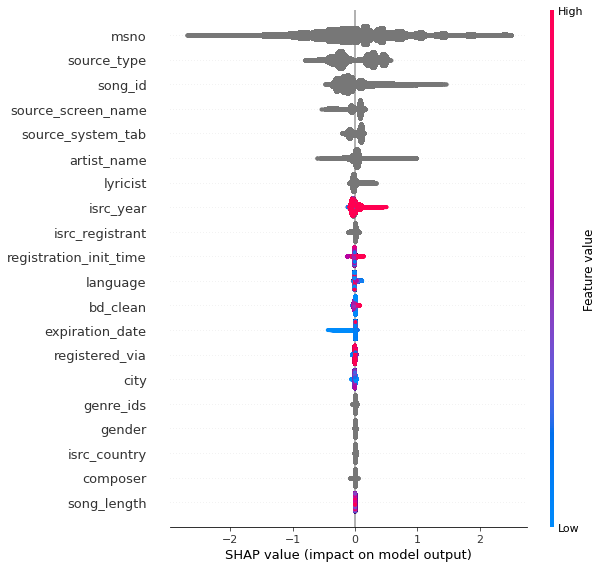

In [51]:
shap.summary_plot(shap_values, train_df)

## Feature engineering
Let's add some features that represent user's interest in a specific genre/artist/composers/... + compare them to their respective popularities

In [66]:
class PreviousEventsCollector:
    def __init__(self):
        self.overall = Counter()
        self.by_user = defaultdict(Counter)
        self.by_user_total = defaultdict(lambda: 0.1)
    
    def add_event(self, user, item_list, should_split=True):
        if should_split:
            item_list = [item.strip() for item in item_list.split('|')]
        else:
            item_list = [item_list]
        overall = 0
        by_user = 0
        
        for item in item_list:
            self.overall[item] += 1
            self.by_user[user][item] += 1
            overall += self.overall[item]
            by_user += self.by_user[user][item]
            self.by_user_total[user] += 1
            
        return overall, by_user, by_user / self.by_user_total[user]
    
Collector = namedtuple('Collector', (
    'overall_col', 
    'by_user_col',
    'ratio_col',
    'source_col', 
    'should_split', 
    'collector'
))

In [67]:
from tqdm import tqdm

In [68]:
genre_collector = Collector('genre_overall', 'genre_by_user', 'genre_ratio', 'genre_ids', True, PreviousEventsCollector())
artist_collector = Collector('artist_overall', 'artist_by_user', 'artist_ratio', 'artist_name', True, PreviousEventsCollector())
composer_collector = Collector('composer_overall', 'composer_by_user', 'composer_ratio', 'composer', True, PreviousEventsCollector())
language_collector = Collector('language_overall', 'language_by_user', 'language_ratio', 'language', False, PreviousEventsCollector())

new_columns = defaultdict(list)
for index, row in tqdm(train_df.iterrows()):
    for collector in [genre_collector, artist_collector, composer_collector, language_collector]:
        ov, bu, ra = collector.collector.add_event(row['msno'], row[collector.source_col], collector.should_split)
        new_columns[collector.overall_col].append(ov)
        new_columns[collector.by_user_col].append(bu)
        new_columns[collector.ratio_col].append(ra)

7377418it [10:16, 11966.67it/s]


In [74]:
for col_name, col in new_columns.items():
    train_df[col_name] = col

In [134]:
train_df.to_csv('train_df.csv')

## Data with extracted features

In [4]:
train_df = pd.read_csv(
    'train_df.csv',
    dtype={
        'msno': 'category', 
        'song_id': 'category', 
        'source_system_tab': 'category',
        'source_screen_name': 'category',
        'source_type': 'category',
        'city': 'category',
        'gender': 'category',
        'registered_via': 'category',
        'registration_init_time': np.int,
        'expiration_date': np.int,
        'bd_clean': np.int,
        'song_length': np.float,
        'genre_ids': 'category',
        'artist_name': 'category',
        'composer': 'category',
        'lyricist': 'category',
        'language': 'category',
        'isrc_country': 'category',
        'isrc_year': np.float,
        'isrc_registrant': 'category',
        'genre_overall': np.float,
        'genre_by_user': np.float,
        'genre_ratio': np.float,
        'artist_overall': np.float,
        'artist_by_user': np.float,
        'artist_ratio': np.float,
        'composer_overall': np.float,
        'composer_by_user': np.float,
        'composer_ratio': np.float,
        'language_overall': np.float,
        'language_by_user': np.float,
        'language_ratio': np.float,
        'user_song_product': np.float
    },
    index_col=0
)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [5]:
train_target = pd.read_csv(TRAIN_FILE, usecols=['target'])

--------------------
CV, fold 1 of 5
Training on 5901934 samples
0:	test: 0.7286843	best: 0.7286843 (0)	total: 1.61s	remaining: 2m 39s
10:	test: 0.7499628	best: 0.7499628 (10)	total: 12.6s	remaining: 1m 41s
20:	test: 0.7593962	best: 0.7593962 (20)	total: 23s	remaining: 1m 26s
30:	test: 0.7637005	best: 0.7637005 (30)	total: 34.1s	remaining: 1m 15s
40:	test: 0.7662091	best: 0.7662091 (40)	total: 44.5s	remaining: 1m 4s
50:	test: 0.7677644	best: 0.7677644 (50)	total: 55.9s	remaining: 53.7s
60:	test: 0.7690614	best: 0.7690614 (60)	total: 1m 7s	remaining: 42.8s
70:	test: 0.7701439	best: 0.7701439 (70)	total: 1m 17s	remaining: 31.7s
80:	test: 0.7709648	best: 0.7709648 (80)	total: 1m 28s	remaining: 20.7s
90:	test: 0.7717377	best: 0.7717377 (90)	total: 1m 39s	remaining: 9.79s
99:	test: 0.7722968	best: 0.7722968 (99)	total: 1m 49s	remaining: 0us

bestTest = 0.7722967838
bestIteration = 99

Evaluating on 1475484 samples
On fold 1, evaluation metrics:
AUC = 0.7723
MAP = 0.6058
Logloss = 0.5690
---

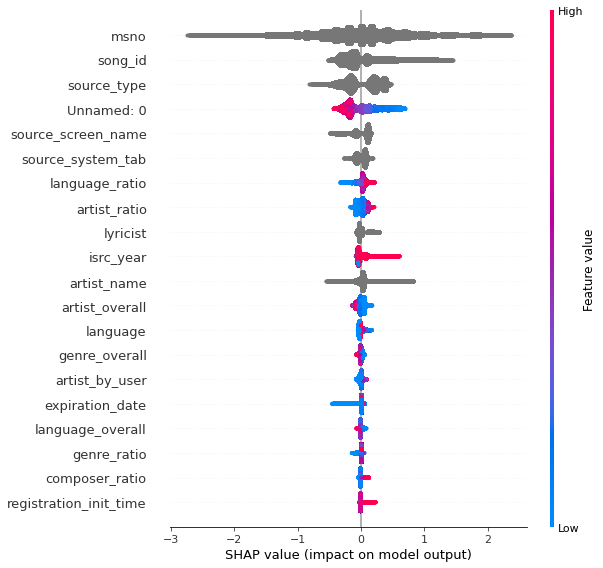

--------------------
CV results:
AUC = 0.7725+-0.0004
MAP = 0.6062+-0.0013
Logloss = 0.5688+-0.0003
--------------------


In [17]:
metric_vals = k_fold_cv(
    train_df, train_target, 
    FOLDS, params, ['AUC', 'MAP', 'Logloss'], 
    cat_features, SEED
)

## BigGraph for node embeddings
We will try to improve the model by incorporating embeddings trained by Facebook's BigGraph. The graph has the following edges:
* user | song they interacted with
* user | gender
* song | genre/composer/artist/lyricist
* song | ISRC data

In [ ]:
!pip install torchbiggraph

In [8]:
train_df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'city', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'bd_clean', 'song_length',
       'genre_ids', 'artist_name', 'composer', 'lyricist', 'language',
       'isrc_country', 'isrc_year', 'isrc_registrant', 'genre_overall',
       'genre_by_user', 'genre_ratio', 'artist_overall', 'artist_by_user',
       'artist_ratio', 'composer_overall', 'composer_by_user',
       'composer_ratio', 'language_overall', 'language_by_user',
       'language_ratio'],
      dtype='object')

In [9]:
with open('biggraph_input.tsv', 'w') as fout:
    
    def write(lhs, e_type, rhs):
        if '\n' in rhs or '\t' in rhs:
            rhs = "RIGHT_SINK"
        if lhs.strip() == "":
            lhs = "LEFT_SINK"
        if rhs.strip() == "":
            rhs = "RIGHT_SINK"
        fout.write(f'{lhs}\t{e_type}\t{rhs}\n')
    
    used_users = set()
    used_songs = set()
    
    for index, row in tqdm(train_df.iterrows()):

        user = row["msno"]
        song = row["song_id"]
        
        write(user, 'user_song', song)
        
        if song not in used_songs:
            write(song, 'song_country', row['isrc_country'])
            write(song, 'song_reg', row['isrc_registrant'])
            
            for artist in row["artist_name"].split('|'):
                write(song, 'song_artist', artist.strip())
            
            for composer in row["composer"].split('|'):
                write(song, 'song_composer', composer.strip())
            
            for lyricist in row["lyricist"].split('|'):
                write(song, 'song_lyricist', lyricist.strip())
            
            for genre in row["genre_ids"].split('|'):
                write(song, 'song_genre', genre.strip())
                
        if not user in used_users:
            write(user, 'user_gender', row["gender"])
                    
        used_songs.add(song)
        used_users.add(user)

7377418it [07:10, 17128.16it/s]


In [10]:
embedding = {}

with open('entity_embeddings.tsv', 'r') as fin:
    for line in fin:
        line = line.strip()
        entity, *embed =  line.split('\t')
        embed = np.array(list(map(float, embed)))
        embedding[entity] = embed

## Explore embeddings
To verify the embeddings returned by BigGraph we will try to find the most similar songs to a random song by specific artist

In [22]:
song_info = songs_df[['song_id', 'artist_name', 'genre_ids', 'composer']].merge(songs_extra_df[['song_id', 'name']], on='song_id', how='left')

In [90]:
def find_similar_songs(entity, k=10):
    if entity not in embedding:
        print('Not in embedding')
        return
    e = embedding[entity]
    sorted_inds = np.argsort(
        song_info['song_id'].map(lambda s_id: 
                                 np.dot(e, embedding[s_id]) / np.linalg.norm(e) / np.linalg.norm(embedding[s_id])
                                 if s_id in embedding else -np.inf).values
    )
    return song_info.iloc[list(reversed(sorted_inds[-k:]))]

In [96]:
def find_similar_songs_to_artist(artist_name, k=10):
    for index, row in song_info[song_info['artist_name'] == artist_name].iterrows():
        s_id = row['song_id']
        if s_id in embedding:
            print(f'Similar to {row["name"]} by {artist_name}')
            return find_similar_songs(s_id)
    return 'Oops'

In [97]:
find_similar_songs_to_artist('Kanye West')

Similar to FML by Kanye West


,song_id,artist_name,genre_ids,composer,name
662,HAk0G8u7Yu2ljX4D7YLcA2P6im4MPx5Rb5Q13wdRL8Q=,Kanye West,1259,Kanye West| Andrew Dawson| Noah Goldstein| Mik...,FML
216117,V3b6JBrDDzPPuJf+Rws2ABhNrhEDSdhoEARqYSvwAi0=,Kanye West,1259,Kanye West| Noah Goldstein| Mike Dean| Chris B...,Waves
218461,tRxwWj7NZvDknWx8c+6ShmzQQVNngqJNyeiOE3CNlBA=,Sigma,1609,Cydel Charles Young|Ernest Dion Wilson|Norman ...,Nobody To Love
565150,a6D4pwKI/wkf8Xo0HjTzUpA2yj7PO1eaSsgXZVfy17U=,Empire Of The Sun,359,Luke Steele| Peter Mayes| Teddy Geiger| Nick L...,Digital Life
57112,/0ivUhg2/tKgBTBlcIA1syDdyqiHpgFCXL9cY8dujM8=,Kanye West,1259,Kanye West| Jeff Bhasker| Patrick Reynolds| Sc...,Paranoid
1561557,A9tejGyaeQsHkexBkxDQTIzQNJF+348fbIv59QKvQcc=,Kid Ink feat. Trey Songz| Juicy J| 2 Chainz & ...,1259,Brian Todd Collins| Dijon McFarlane| Christian...,Show Me REMIX
1418319,x28MaspiHskxrZRCgi8Uo8CzEizl2IxjFS95+lk4Sx0=,Kid Cudi,1259,Jeff Bhasker| Scott Mescudi| P. Reynolds| Clau...,My World
177940,wo5XLWpAVwsg1VoWNjQcKyh1G9e44tiDSatU7joR/Cw=,Kanye West,1259,Kanye West| Jeff Bhasker| Jenny-Bea Englishman...,RoboCop
766536,WgqKzeiPRZGnvV/FNM2mBUDBiiQvIucQSlnQgq3uKKA=,Kanye West,1259,Kanye West|Patrick Reynolds|Scott Mescudi|Dext...,Paranoid
799834,dR15swqErSceTlpZeSaWtcGw6mYDqh2a4qkAsK2exmQ=,Empire Of The Sun,359,Luke Steele| Peter Mayes| Nick Littlemore| Jon...,High And Low


In [98]:
find_similar_songs_to_artist('Green Day')

Similar to Jesus Of Suburbia by Green Day


,song_id,artist_name,genre_ids,composer,name
2329,WwMDAw7ltWXOGAackjsX2OHr8e0ZpFXxF/fPUk7XG20=,Green Day,359,Green Day,Jesus Of Suburbia
2607,ExybIL1v0Z+Nu/H8f6hNgYmGrGwT6Js4O8a5tkgV/hE=,Green Day,359,Green Day,Extraordinary Girl/Letterbomb
726318,owZ0+9UwIs4TXEbn39ifbndfLbm3BmxrDVVbpIniJAU=,Green Day,359,Green Day,Carpe Diem
15989,K/fadrEdr3sKrmhGC6c5mBDcKUjPVXb+7fQMIgsN+n0=,Green Day,359,Green Day,Fell For You
399313,PQQ3NKWH9EMsZ6+o9P7Pcijbn6I9zLFqd/J81/CdA/M=,Green Day,359,Green Day,Cigarettes And Valentines
576638,s8RCaajM6/pE4oeIqzK0WYWgeHFsw+kJsWzNTORRUtE=,Green Day,359,Green Day,American Eulogy: Mass Hysteria / Modern World
451564,wTsvtmFqGq0afZu5xogCx7hTFT5eSKtKmBXGSdJLaRk=,Green Day,359,Green Day,Last of the American Girls
321247,CIibpJfwUvfGUeE0bU0IqJrwBt+/Dr4VaPBj/N9vRSU=,Green Day,359,Green Day,Redundant
317156,gyDHwDP+4B4KA2Bz2fpSyuEZWg05HJsKY6pjvgMhJ1c=,Green Day,359,Green Day,When I Come Around
91820,A3bIlzwZhOHiZovnd3zDg0LyZIk7w/23QyajEC5LsH4=,Green Day,359,Green Day,Amy


In [99]:
find_similar_songs_to_artist('BABYMETAL')

Similar to メギツネ by BABYMETAL


,song_id,artist_name,genre_ids,composer,name
1636,EAzABv2vcLiidXQmDPocuXlv4jAUKtGVNfYeQARNKcY=,BABYMETAL,242|2022,NORiMETAL,メギツネ
539142,fvBzcBjGNL8hS8ShbKw8XddqHH/Jlz8uGbjokrBgDzA=,BABYMETAL,242|2022,NORiMETAL,ヤバッ！
23040,6+7tpHGZXdp60vFTwmkXdsQSj/LUVV4mALDjYjiHulE=,BABYMETAL,242|2022,TAKESHI UEDA,ギミチョコ!!
60959,J/n4X+kQPy029hixuBUG31l8JCT8xUfSllzGRJd7RF4=,BABYMETAL,242|2022,TSUBOMETAL,Sis. Anger
134728,IW1pU2CV7PgyA6QSkisklVJecxuY1cqHv1YtkMrvzPg=,BABYMETAL,242|2022,KxBxMETAL/ TUBOMETAL/ TAKEMETAL,イジメ、ダメ、ゼッタイ
603382,cLBz9UyCb5Pdlo9NAmEvSasDWBSKPcFDaaubrTveYC0=,BABYMETAL,242,Yuyoyuppe,悪夢の輪舞曲 (Live)
362383,hUs1uV/wuLlcP+ih8jzgl7BAeEvq6jdgr6RKs3c8+eE=,BABYMETAL,242|2022,Mish-Mosh/NORiMETAL/KYT-METAL,Road of Resistance
69453,YRWpNpfui+mW0AMbf6uJBQWSMsRzcmScPyXRCNsYs1o=,BABYMETAL,242|2022,Yuyoyuppe,悪夢の輪舞曲
76224,30h+b4rGfYuUZuQzeWt+Suf9kS5ssCiiDlqnOaORTuA=,BABYMETAL,242|2022,YOSHIFU-METAL,NO RAIN| NO RAINBOW
23973,/0f/5TSWAKytBn2UVVQFxqoqZs8QbiKR+iJ5zm7VnTo=,BABYMETAL,242|2022,Yuyoyuppe,GJ！


In [100]:
find_similar_songs_to_artist('2Pac')

Similar to Keep Ya Head Up by 2Pac


,song_id,artist_name,genre_ids,composer,name
2538,JTV5JzX0KQ/rgP99o9F7Rlurvz5K8SxE8hyPQZUPvQQ=,2Pac,1259,Daryl Anderson| Stan Vincent| Tupac Shakur| Ro...,Keep Ya Head Up
214825,32wmWETqEsTOnxBbYQuzY2p6tHoXJJeoBq19lgke7QQ=,Bone Thugs-N-Harmony,1259,Giorgio Tuinfort| Steven Howse| Charles Scrugg...,I Tried
1673732,+JZiC1/aM5kPrdZtqPwoGjRwc+v2gTuGX5NIRVvVi4A=,Ice Cube,1259,Melvin Glover|Sylvia Robinson|O'Shea Jackson|E...,Check Yo Self
99454,Zpwwina11k93A0pWcp/IEAIM8DGFzKesDc3Urgl06No=,E-Dubble,1259,Evan Wallace,What It Do
791976,/dzrBMurw7FwKzuE0UtlmgQ3T2tXtxQo5rg9qrwguRs=,Janet Jackson,465,Janet Jackson| Terry Lewis| Valerie Simpson| P...,My Need
143404,r2R6M/UespqjVF0jbgrE3KARKr0BKXChtu8XMzhTv2A=,Ice Cube,1259,Sylvia Robinson| Ronald Isley| Harry Ray| O'Sh...,It Was A Good Day
86607,Kqi+e/Mxiog9GucyB47wC81j/oxGpH1TacyA3qBlsPE=,2Pac,1259,Anthony Hamilton| Johnny Jackson| Tupac Shakur...,Thugz Mansion
254696,xLBiXij/8+j0MIfTqV+7M0EuaeQzjBqUxwv7wjqBUp4=,Bone Thugs-N-Harmony,1259,Steven Howse| Charles Scruggs| Anthony Henderson,Flowmotion
556702,alXq60yl986EjRg2mKYu/SYlcPZ2GbXxrPStiaV4DhE=,Joss Stone,465,Joss Stone| Antonia Jenae| Javier Colon,Mr. Wankerman
604821,8mCy5rzuy1kE3peA+KWnGvNpq7OZv27BhtFArM/UyVI=,Ice Cube,1259,Sylvia Robinson| O'Shea Jackson| Melvin Glover...,Check Yo Self


In [101]:
find_similar_songs_to_artist('The Notorious B.I.G.')

Similar to #!*@ You Tonight [Featuring R. Kelly] (Explicit Album Version) by The Notorious B.I.G.


,song_id,artist_name,genre_ids,composer,name
2634,e1oEtd2+aZcuUiNEY4aR2xPRUC54f14+gZJKqH0k0YQ=,The Notorious B.I.G.,1259,NaN,#!*@ You Tonight [Featuring R. Kelly] (Explici...
557786,/1NpuyetR8CPatXlb5AW6NV2tLMfCJzV3gbODa3H624=,112,139|125|109,NaN,Why
94205,Khu+2BF7EZfITk9up5KpFnOFDq+AJvE/wrCdhskNV0I=,Yfn Lucci,1259,NaN,Key to the Streets
866246,zQHJnEMMHlRwOhsfwD7AKQfbDKyJjoOSXq8w/dOYMHQ=,Snoop Dogg,1259,NaN,Dogg Pound Ganstaville
1440891,kOtUjp7ck8AEciJjFlBzUVG0iuADqgTMGSUAEG+r5n4=,Snoop Dogg,1259,NaN,2 of Americaz Most Wanted
1891988,AE3H//4UIHSOwcuN07aQ78EA2SHD9B31rFBfEjlq/Mg=,Snoop Dogg,1259,NaN,Friends
41940,NWFCuDwlzLCsnD7iq1yVAtXKy3zy8co+VmpdPXCvIcE=,The Notorious B.I.G.,1259,NaN,Big Poppa
209936,B9dWm8/0HsjfrWp62JW5eVdWnMyLuFi4i2A04CXEQPQ=,DAY26,139,NaN,Come With Me
160539,NSnqtc1WU4hkvp1agHyr77Ed8CXIgX3lZWKyGE9s+AU=,The Groove Masters,139,NaN,I'll Be Missing You
1711725,J/gNJzMcnV91rIVveUTCzI4VNIAcv2yZoKyBs4Zxb9I=,The Notorious B.I.G.,1259,NaN,Juicy


In [122]:
find_similar_songs_to_artist('Iron Maiden')

Similar to Rainmaker by Iron Maiden


,song_id,artist_name,genre_ids,composer,name
34515,jvj1PlsCOvhwA4HWM2u4QsfyZDtwHW1fQC7L1JCsA8M=,Iron Maiden,465,Bruce Dickinson| Dave Murray| Steve Harris,Rainmaker
360641,z1oCVsOB+SptYNSNZVfhzYjRlmaZjTmrdmrgLzZgv6c=,The Fratellis,2022,Gordon McRory| John Lawler| Barry Wallace,Whistle For The Choir
2097185,XvaRW1arZYUiXU9ABpUviVnYJwBvEmdFV7XtyFzKDUE=,The Smashing Pumpkins,2022,William Patrick Corgan,Drum + Fife
1038969,MdU/jtqjVhkQXuXldQXfC2VfMPWboeXXOBJYFCJCvms=,Madonna,465,Madonna| Christian Karlsson| Henrik Jonback.| ...,How High
291656,qZCsbDk2gEr+elHpnFbSZ4V6QUgGLlRrnmLXR01RfPE=,Iron Maiden,465,Bruce Dickinson| Steve Harris| Adrian Smith,The Longest Day
1661473,VwBkuTkZKNqmdJ6OT9vutaP7TM3cCy3UH9gEFnifnXg=,The Fratellis,2022,John Lawler|Gordon McRory|Barry Wallace,Whistle For The Choir
36339,G28xoIlNwj7cU6nJ9q5KmPkda0eVNLSlg8UCfNfzTJY=,Elton John,465,Elton John,Goodbye Yellow Brick Road
636847,iBwYsQK+rnzjVG8nGMtzQsTp9TgWgVEFXRnHq7xA2ZI=,The Strokes,2022,Julian Casablancas| Moretti| Valensi,OBLIVIUS
371218,nb+H4Vt4WefwiuMO1t7Gl/2vJX2sMYKg4yDzy4O54HE=,Iron Maiden,465,Steve Harris,Wrathchild
897057,aSATrg5IRmivMF4tpnqkOjCJDtl4pjRi7v71D7lC3ZM=,The Pointer Sisters,465,Andy Goldmark| Bruce Roberts,Goldmine


In [125]:
find_similar_songs_to_artist('The Beatles')

Similar to Eleanor Rigby / Julia by The Beatles


,song_id,artist_name,genre_ids,composer,name
11611,HKQx7UOCNsC0pYvtGptrVs7aYxgNAQv2q1InH+HKil8=,The Beatles,2022,John Lennon| Paul McCartney,Eleanor Rigby / Julia
34602,OYI41C6dkjoX3D2Wz3RERzCwsMkG7dfPLPA6ecFEVEg=,The Beatles,2022,John Lennon| Paul McCartney,Revolution
1696360,pjYeZ1wa6D08kXIe1qooXL0C3/tNln0mb+j+ERTgBaA=,The Beatles,2022,John Lennon| Paul McCartney,A Day In The Life
107750,kvhuFHLhVRY6rsye+r5UhAfPQO0X4V1NoHqUm2Y4WIc=,The Beatles,2022,John Lennon| Paul McCartney,Because
1060139,B99CK01JwWsiLNg71qCpFde7lwaDUlAC53tKmQB4LJI=,The Beatles,2022,John Lennon| Paul McCartney,Blackbird/Yesterday
269262,cWTSYdhkriN62dCBi2lvoYlnTZ+HbgwVH+2BR0ClIj0=,The Beatles,2022,John Lennon| Paul McCartney,Hey Bulldog
142665,fKnJTCbbtdHRF2yu09hWCl0j8dz0jk6s69fZG0uNFLQ=,The Beatles,2022,John Lennon| Paul McCartney,Help!
217084,F5Sa48g7eE09L5AWRBcJtNkhRJlieLFtLrg5DHYj0Kg=,The Beatles,2022,John Lennon| Paul McCartney,Girl
1950270,O8pfdYsYRVVkJ7Li+anDPU6hZCw2aceDBnkTY5UYFA0=,The Beatles,2022,John Lennon| Paul McCartney,Dig A Pony
89835,ByrufgEhASRd694XEK1oJvnEERCy8NglBrymyF7p560=,The Beatles,2022,John Lennon| Paul McCartney,All You Need Is Love


## Enhance catboost with embeddings

In [126]:
train_df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'city', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'bd_clean', 'song_length',
       'genre_ids', 'artist_name', 'composer', 'lyricist', 'language',
       'isrc_country', 'isrc_year', 'isrc_registrant', 'genre_overall',
       'genre_by_user', 'genre_ratio', 'artist_overall', 'artist_by_user',
       'artist_ratio', 'composer_overall', 'composer_by_user',
       'composer_ratio', 'language_overall', 'language_by_user',
       'language_ratio'],
      dtype='object')

In [131]:
train_df['user_song_product'] = train_df.apply(
    lambda row: np.dot(embedding[row['msno']], embedding[row['song_id']]) / 
    np.linalg.norm(embedding[row['msno']]) /
    np.linalg.norm(embedding[row['song_id']]),
    axis=1
)

--------------------
CV, fold 1 of 5
Training on 5901934 samples
0:	test: 0.7252520	best: 0.7252520 (0)	total: 1.54s	remaining: 2m 32s
10:	test: 0.7469247	best: 0.7469247 (10)	total: 13.4s	remaining: 1m 48s
20:	test: 0.7586593	best: 0.7586593 (20)	total: 25.3s	remaining: 1m 35s
30:	test: 0.7634199	best: 0.7634199 (30)	total: 36.1s	remaining: 1m 20s
40:	test: 0.7659515	best: 0.7659515 (40)	total: 47.3s	remaining: 1m 8s
50:	test: 0.7675822	best: 0.7675822 (50)	total: 59.2s	remaining: 56.9s
60:	test: 0.7689528	best: 0.7689528 (60)	total: 1m 10s	remaining: 45.1s
70:	test: 0.7698879	best: 0.7698879 (70)	total: 1m 21s	remaining: 33.5s
80:	test: 0.7708318	best: 0.7708318 (80)	total: 1m 33s	remaining: 21.8s
90:	test: 0.7715095	best: 0.7715095 (90)	total: 1m 43s	remaining: 10.3s
99:	test: 0.7720968	best: 0.7720968 (99)	total: 1m 53s	remaining: 0us

bestTest = 0.7720968326
bestIteration = 99

Evaluating on 1475484 samples
On fold 1, evaluation metrics:
AUC = 0.7721
MAP = 0.6048
Logloss = 0.5694


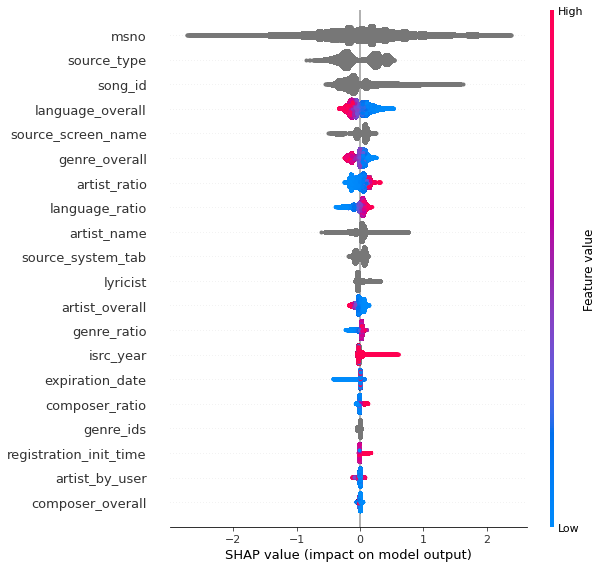

--------------------
CV results:
AUC = 0.7723+-0.0004
MAP = 0.6056+-0.0014
Logloss = 0.5693+-0.0003
--------------------


In [140]:
metric_vals = k_fold_cv(
    train_df, train_target, 
    FOLDS, params, ['AUC', 'MAP', 'Logloss'], 
    cat_features, SEED
)

In [9]:
user_embed = {}

def get_user_embed(user):
    if user in user_embed:
        return user_embed[user]
    user_embed[user] = np.zeros(32)
    count = 0
    for song in train_df.loc[train_df['msno'] == user]['song_id']:
        user_embed[user] += embedding[song]
        count += 1
    user_embed[user] /= count
    return user_embed[user]

In [11]:
train_df['user_song_product'] = train_df.apply(
    lambda row: np.dot(get_user_embed(row['msno']), embedding[row['song_id']]) / 
    np.linalg.norm(get_user_embed(row['msno'])) /
    np.linalg.norm(embedding[row['song_id']]),
    axis=1
)

--------------------
CV, fold 1 of 5
Training on 5901934 samples
0:	test: 0.7329004	best: 0.7329004 (0)	total: 1.5s	remaining: 2m 28s
10:	test: 0.7507399	best: 0.7507399 (10)	total: 11.9s	remaining: 1m 36s
20:	test: 0.7611978	best: 0.7611978 (20)	total: 21.9s	remaining: 1m 22s
30:	test: 0.7659208	best: 0.7659208 (30)	total: 32.7s	remaining: 1m 12s
40:	test: 0.7686842	best: 0.7686842 (40)	total: 43.4s	remaining: 1m 2s
50:	test: 0.7703317	best: 0.7703317 (50)	total: 54.5s	remaining: 52.3s
60:	test: 0.7716990	best: 0.7716990 (60)	total: 1m 5s	remaining: 41.7s
70:	test: 0.7727905	best: 0.7727905 (70)	total: 1m 16s	remaining: 31.2s
80:	test: 0.7736900	best: 0.7736900 (80)	total: 1m 27s	remaining: 20.4s
90:	test: 0.7745461	best: 0.7745461 (90)	total: 1m 37s	remaining: 9.66s
99:	test: 0.7750893	best: 0.7750893 (99)	total: 1m 47s	remaining: 0us

bestTest = 0.7750893201
bestIteration = 99

Evaluating on 1475484 samples
On fold 1, evaluation metrics:
AUC = 0.7751
MAP = 0.6074
Logloss = 0.5666
--

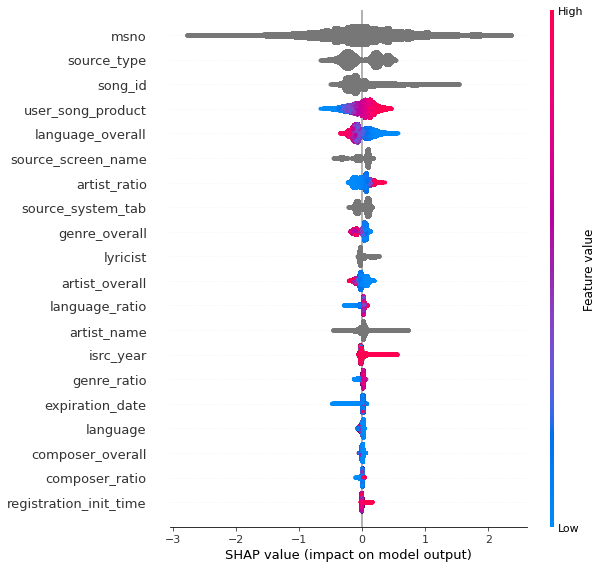

--------------------
CV results:
AUC = 0.7755+-0.0005
MAP = 0.6087+-0.0013
Logloss = 0.5663+-0.0004
--------------------


In [22]:
metric_vals = k_fold_cv(
    train_df, train_target, 
    FOLDS, params, ['AUC', 'MAP', 'Logloss'], 
    cat_features, SEED
)